In [9]:
import numpy as np 
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")

%matplotlib inline

Here's a link to the dataset: https://vis-www.cs.umass.edu/lfw/

I download the dataset where it says:

**[new] All images aligned with deep funneling**

**(111MB, md5sum 68331da3eb755a505a502b5aacb3c201)**

**REMEBER TO CHANGE THE FOLDER PATHS**


In [ ]:
folder_path = "D:/CourseStuff/AI/Notebooks/Project/lfw-deepfunneled"

In [ ]:
len(os.listdir(folder_path))

5749

We have 5749 folders in the dataset where each folder is named after a specific person and usually contains from one to three images of that person.

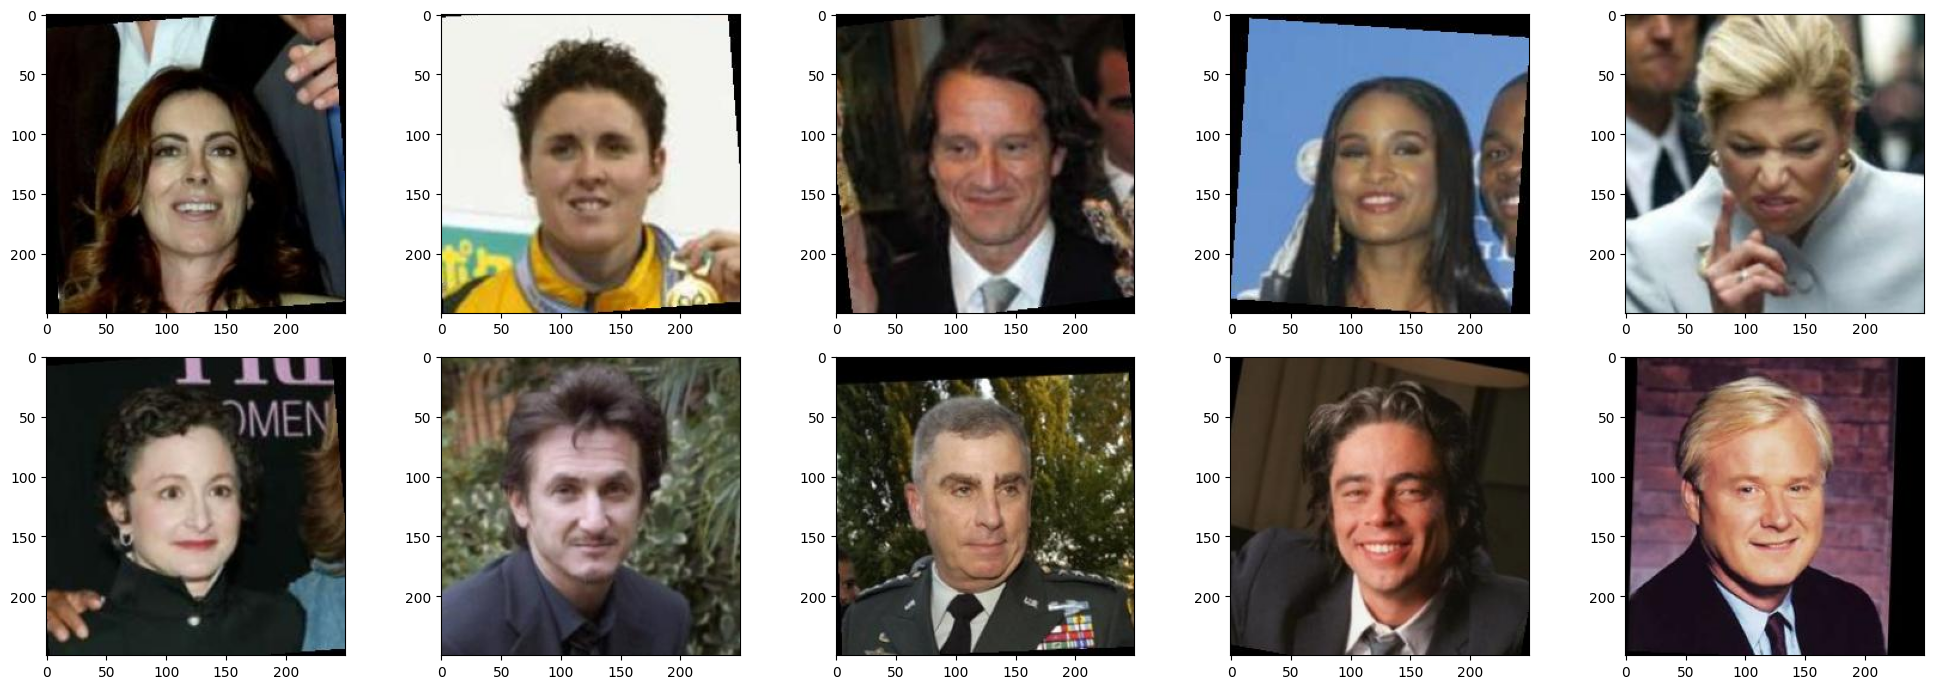

In [ ]:
fig, axes = plt.subplots(figsize=(20,7) ,nrows=2, ncols=5)
plot_index = 0

image_paths = []

for i in range(10):
    foldername = os.listdir(folder_path)[random.randint(0, 5748)]
    file_path = folder_path + f'/{foldername}'
    filename = os.listdir(file_path)[0]
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Construct the full file path
        image_path = os.path.join(file_path, filename)

        image_paths.append(image_path)

        # Read the image using cv2
        img = cv2.imread(image_path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[plot_index // 5, plot_index % 5].imshow(img)

        plot_index += 1

plt.tight_layout()
plt.show()

So this is called the labeled faces in the wild dataset the faces are aligned to the center of the image to make the learning proccess easier but this dataset doesn't have annotations as it was meant for face recognition not detection but we can get around that by annotating the images ourselves using opencv's pre-trained classifier for face detection.

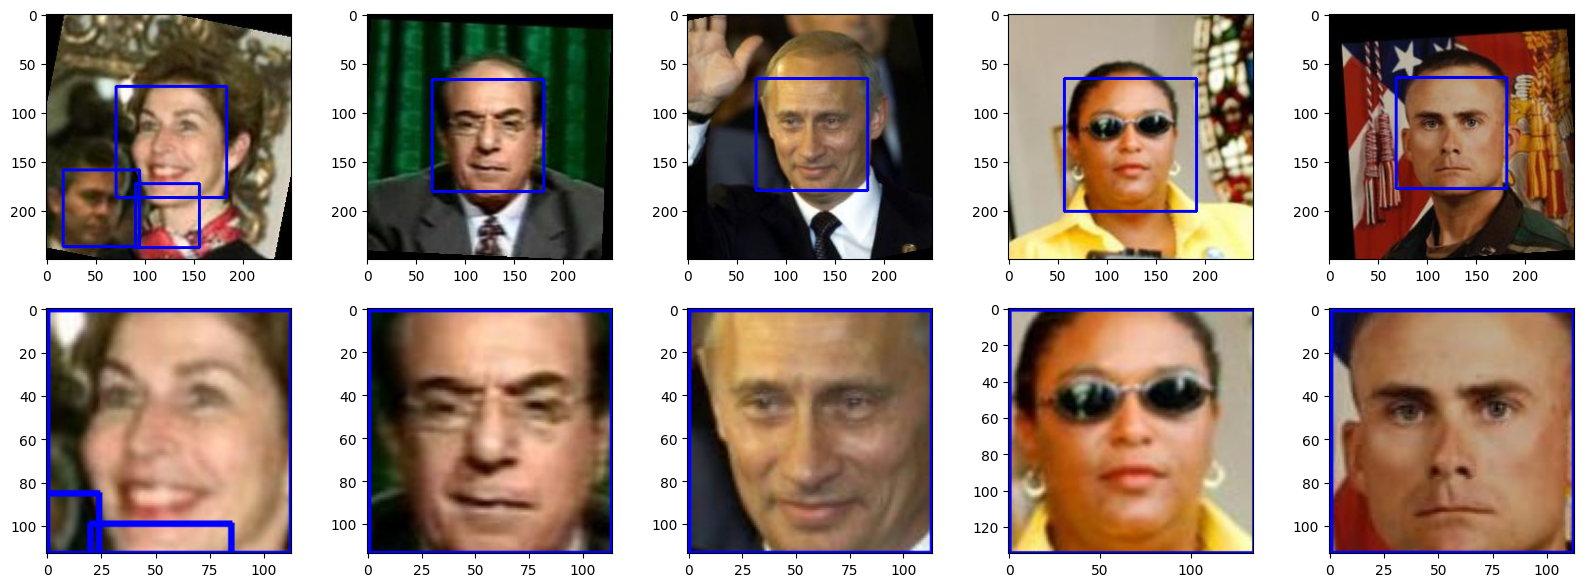

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

fig, axes = plt.subplots(figsize=(20,7) ,nrows=2, ncols=5)
plot_index = 0

for i in range(5):
    foldername = os.listdir(folder_path)[random.randint(0, 5748)]
    file_path = folder_path + f'/{foldername}'
    filename = os.listdir(file_path)[0]
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Construct the full file path
        image_path = os.path.join(file_path, filename)

        # Read the image using cv2
        img = cv2.imread(image_path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Perform face detection
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

        # Draw bounding boxes around the detected faces
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # getting the region of interest
        face_roi = img[y:y+h, x:x+w]

        axes[0, plot_index % 5].imshow(img)

        axes[1, plot_index % 5].imshow(face_roi)

        plot_index += 1

plt.show()

*Doing it this way is not a 100% reliable and may or may not be a good long term solution as the classifier will probably miss some faces but in the mean time this more than enough as a proof of concept before actually finding a larger annotated dataset.*

---

As machine learning algorithms like support vector machines can't deal with raw data as easily as neural networks we have to do some feature extraction ourselves and one of the most popular feature extraction algorithms used in face detection is HOG or Histogram of Gradients.

In [ ]:
from skimage.feature import hog
from skimage import exposure

def extract_hog_features(face, visualize=False):
    face = cv2.resize(face, (64, 64))
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)

    if visualize:
        features, hog_image = hog(face, orientations=orientations, pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block, visualize=visualize, block_norm='L2-Hys')

        return features.flatten(), hog_image
    else:
        features = hog(face, orientations=orientations, pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block, visualize=visualize, block_norm='L2-Hys')

        return features.flatten()

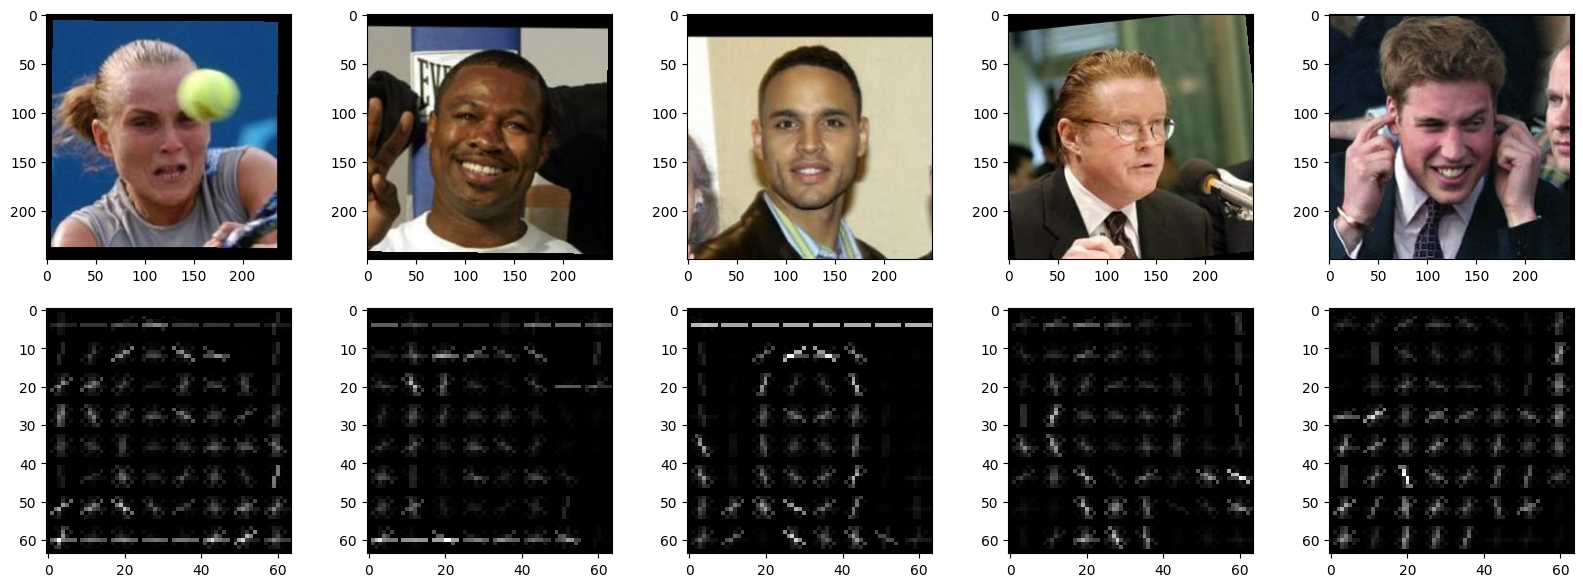

Features dimensions: 1764


In [ ]:
fig, axes = plt.subplots(figsize=(20,7) ,nrows=2, ncols=5)
plot_index = 0

for i in range(10):
    foldername = os.listdir(folder_path)[random.randint(0, 5748)]
    file_path = folder_path + f'/{foldername}'
    filename = os.listdir(file_path)[0]
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Construct the full file path
        image_path = os.path.join(file_path, filename)

        # Read the image using cv2
        img = cv2.imread(image_path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

        # Draw bounding boxes around the detected faces
        for (x, y, w, h) in faces:
            face_roi = gray[y:y+h, x:x+w]

        features, hog_image = extract_hog_features(gray, True)

        axes[0, plot_index % 5].imshow(img, cmap='gray')

        axes[1, plot_index % 5].imshow(hog_image, cmap='gray')

        plot_index += 1

plt.savefig('output_plot1.png')
plt.show()
print(f'Features dimensions: {features.size}')

In [ ]:
def generate_dataframe(folder_path, face_cascade):
    hog_features = []

    for foldername in os.listdir(folder_path):
        file_path = folder_path + f'/{foldername}'
        for filename in os.listdir(file_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Construct the full file path
                image_path = os.path.join(file_path, filename)

                # Read the image using cv2
                img = cv2.imread(image_path)

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                # faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

                # # Draw bounding boxes around the detected faces
                # for (x, y, w, h) in faces:
                #     face_roi = gray[y:y+h, x:x+w]

                features = extract_hog_features(gray, False)

                hog_features.append(features)

                    # del face_roi
                # del img, gray, faces

    data = pd.DataFrame(hog_features)

    return data

In [ ]:
df = generate_dataframe(folder_path, face_cascade)

In [ ]:
df.shape

(13233, 1764)

The website that hosted the dataset says it has 13233 images the cascading classifier probably over classified but let's go with it for now.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13233 entries, 0 to 13232
Columns: 1764 entries, 0 to 1763
dtypes: float64(1764)
memory usage: 178.1 MB


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,0.000000,0.000000,0.000000,0.336669,0.336669,0.047411,0.063609,0.000000,0.000000,0.122375,...,0.118872,0.102585,0.029258,0.319806,0.190887,0.387406,0.111640,0.011150,0.020466,0.108247
1,0.154104,0.130361,0.113794,0.042236,0.250964,0.110892,0.034418,0.030164,0.192733,0.062647,...,0.000000,0.001930,0.000000,0.254485,0.108068,0.254485,0.233877,0.026808,0.029170,0.015256
2,0.103994,0.100952,0.000000,0.000000,0.001872,0.000000,0.000000,0.000000,0.000000,0.359772,...,0.190798,0.297440,0.001627,0.297440,0.000000,0.011639,0.000000,0.000000,0.000000,0.147892
3,0.119485,0.000000,0.011265,0.000000,0.031863,0.035624,0.022530,0.000000,0.000000,0.159314,...,0.090524,0.072893,0.023600,0.003327,0.009109,0.397466,0.397466,0.397466,0.007766,0.000000
4,0.247475,0.065305,0.000000,0.000000,0.048058,0.000000,0.001011,0.000000,0.282698,0.282698,...,0.034016,0.058392,0.020417,0.025300,0.021900,0.398047,0.024769,0.398408,0.014805,0.003169


Adding the label

In [ ]:
df['label'] = 1

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1755,1756,1757,1758,1759,1760,1761,1762,1763,label
0,0.000000,0.000000,0.000000,0.336669,0.336669,0.047411,0.063609,0.000000,0.000000,0.122375,...,0.102585,0.029258,0.319806,0.190887,0.387406,0.111640,0.011150,0.020466,0.108247,1
1,0.154104,0.130361,0.113794,0.042236,0.250964,0.110892,0.034418,0.030164,0.192733,0.062647,...,0.001930,0.000000,0.254485,0.108068,0.254485,0.233877,0.026808,0.029170,0.015256,1
2,0.103994,0.100952,0.000000,0.000000,0.001872,0.000000,0.000000,0.000000,0.000000,0.359772,...,0.297440,0.001627,0.297440,0.000000,0.011639,0.000000,0.000000,0.000000,0.147892,1
3,0.119485,0.000000,0.011265,0.000000,0.031863,0.035624,0.022530,0.000000,0.000000,0.159314,...,0.072893,0.023600,0.003327,0.009109,0.397466,0.397466,0.397466,0.007766,0.000000,1
4,0.247475,0.065305,0.000000,0.000000,0.048058,0.000000,0.001011,0.000000,0.282698,0.282698,...,0.058392,0.020417,0.025300,0.021900,0.398047,0.024769,0.398408,0.014805,0.003169,1


Now we have our face data but this dataset only contains faces which is just one class. we need to add some non-faces in the dataset because we need to provide another class to the model so it's able to differentiate between faces and non-faces.

As iam struggling to find a dataset i decided to use web scraping using selenium.

If you want to run the web scraper you should first do a couple of things:

- 1) Download a chrome driver with the same version of your browser. Here's a link to the one i downloaded 	https://storage.googleapis.com/chrome-for-testing-public/121.0.6167.184/win64/chromedriver-win64.zip
or https://googlechromelabs.github.io/chrome-for-testing/#stable

- 2) Specify the path of your chrome driver in the code.

- 3) You can add more images by adding more search queries in the to self.to_search_for list in the Bot class' \_\_init__ method.

- 4) You may want to change the path where it downloads the images from the self.path attribute in the Bot's \_\_init__ method.

You may have to do more changes on the code that i haven't anticipated sorry for that :)

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
import pathlib

## CHANGE THE DRIVER PATH HERE
DRIVER_PATH = 'chromedriver.exe'
GOOGLE = 'https://www.google.com'
GOOGLE_IMAGE_CLASS = 'rg_i Q4LuWd'

class Bot(webdriver.Chrome):
    def __init__(self,headless=True, num_image=100):
      ## HERE YOU CAN ADD MORE QUERIES TO SEARCH FOR AND FOR EVERY
      ## QUERY IT WILL DOWNLOAD num_image OF IMAGES FROM GOOGLE IMAGES
        self.to_search_for = [
    'landscape', 'sunset', 'beach', 'mountain', 'cityscape',
    'wildlife', 'flowers', 'architecture', 'technology', 'food',
    'abstract art', 'travel', 'sports cars', 'animals', 'space',
    'underwater', 'rainforest', 'celebrities', 'vintage', 'art',
    'fashion', 'movies', 'music', 'history', 'science',
    'fitness', 'health', 'education', 'books', 'photography',
    'gaming', 'motivation', 'cars', 'motorcycles', 'aviation',
    'anime', 'cartoons', 'comics', 'dance', 'fitness', 'yoga',
    'science fiction', 'fantasy', 'gadgets', 'memes', 'quotes',
    'technology', 'puppies', 'kittens', 'cute animals', 'meme',
    'cooking', 'desserts', 'fruit', 'vegetables', 'nature',
    'waterfalls', 'rivers', 'oceans', 'desert', 'rain', 'snow',
    'fireworks', 'celebrations', 'festivals', 'vintage cars',
    'modern art', 'street art', 'sunrise', 'moon', 'stars',
    'constellations', 'universe', 'planets', 'galaxy', 'nebula',
    'sports', 'extreme sports', 'adventure', 'exploration',
    'abstract photography', 'macro photography', 'black and white',
    'colorful', 'minimalism', 'geometric patterns', 'science',
    'technology', 'computers', 'coding', 'robots', 'AI', 'VR',
    'AR', 'space exploration', 'NASA', 'astronomy'
]

        self.num_image = num_image
        self.service = Service(DRIVER_PATH)
        self.path = pathlib.Path('non-face_images')
        self.current_image = 0
        self.options = Options()
        if headless:
            self.options.add_argument('--headless')
        self.wait = WebDriverWait(self,4)
        super().__init__(service=self.service,options=self.options)
        self.implicitly_wait(10)


    def get_search_page(self):
        self.maximize_window()
        self.get(GOOGLE)
        # change language to english in google
        if self.find_element(By.LINK_TEXT,'English'):
            self.find_element(By.LINK_TEXT,'English').click()


    def search(self, search, element):
        # search google and submit
        textbox = self.find_element(By.TAG_NAME, f'{element}')
        textbox.clear()
        textbox.send_keys(search)
        textbox.submit()


    def google_images_page(self):
        # click on Images
        images_link = self.find_element(By.LINK_TEXT,'Images')
        images_link.click()


    def screenshot_images(self):
        images = self.find_elements(By.CSS_SELECTOR,f'img[class="{GOOGLE_IMAGE_CLASS}"]')
        body = self.find_element(By.TAG_NAME,'body')
        while len(images) < self.num_image:
                for i in range(8):
                    body.send_keys(Keys.PAGE_DOWN)
                images = self.find_elements(By.CSS_SELECTOR,f'img[class="{GOOGLE_IMAGE_CLASS}"]')
                try:
                    self.wait.until(
                    EC.visibility_of_element_located((images[-10]))
                    )
                except:
                    for i in range(8):
                        body.send_keys(Keys.PAGE_DOWN)


        # make a folder to store images based on the search if it doesn't exist.
        if not self.path.exists():
            self.path.mkdir()

        # take a screenshot of the images and then save them.
        for i in range(self.num_image):
            images[i].screenshot(f'{self.path}\\img{self.current_image}.png')
            self.current_image += 1


    def __exit__(self, exc_type , exc, traceback):
        self.quit()

## YOU CAN SPECIFY THE NUMBER OF IMAGES TO DOWNLOAD FOR EVERY QUERY FROM HERE
## BUT I DON'T ADVISE RAISING IT ABOVE 70
## ALSO YOU CAN SEE WHAT THE SCRAPER IS DOING IF YOU FLIP HEADLESS TO FALSE
with Bot(headless=False, num_image=70) as bot:
    bot.get_search_page()
    bot.search(bot.to_search_for[0], 'textarea')
    bot.google_images_page()
    bot.screenshot_images()
    for query in bot.to_search_for[1:]:
        bot.search(query, 'input')
        bot.screenshot_images()


**CHANGE THE PATH TO THE NON-FACE IMAGES**

In [ ]:
non_face_path = 'D:/CourseStuff/AI/Notebooks/Project/non-face_images'

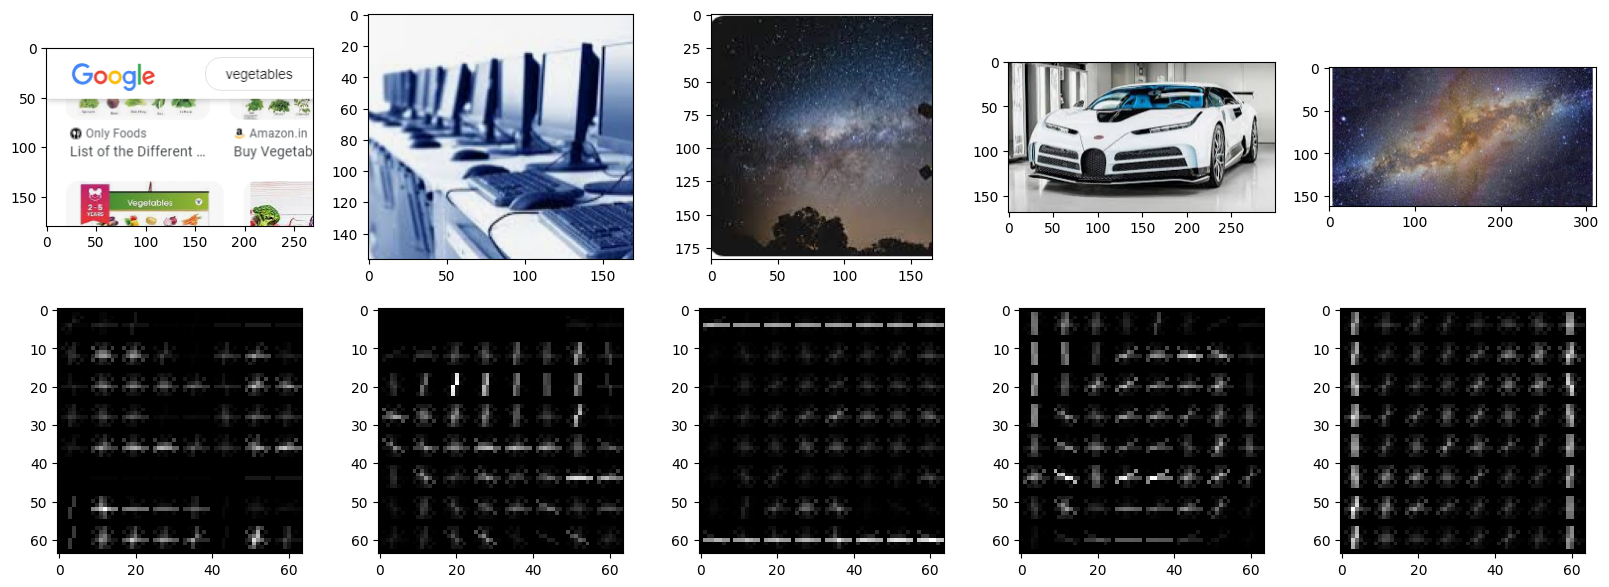

In [ ]:
fig, axes = plt.subplots(figsize=(20,7) ,nrows=2, ncols=5)
plot_index = 0

hog_features = []
cropped_faces = []

for i in range(10):
    filename = os.listdir(non_face_path)[random.randint(0, 6700)]
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Construct the full file path
        image_path = non_face_path + '/' + filename

        # Read the image using cv2
        img = cv2.imread(image_path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

        if len(faces):
            continue

        features, hog_image = extract_hog_features(gray, True)

        axes[0, plot_index % 5].imshow(img, cmap='gray')

        axes[1, plot_index % 5].imshow(hog_image, cmap='gray')

        plot_index += 1

plt.show()

Well it's not a great web scraping script but looks like it does the job, although i think that a better dataset with more backgrounds than random stuff would be better.

In [ ]:
def generate_dataframe_non_face(folder_path, face_cascade):
    hog_features = []

    for filename in os.listdir(non_face_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Construct the full file path
            image_path = folder_path + '/' + filename

            image_paths.append(image_path)

            # Read the image using cv2
            img = cv2.imread(image_path)

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10)

            if len(faces):
                continue

            features = extract_hog_features(gray)

            hog_features.append(features)

            del img, gray, faces

    data = pd.DataFrame(hog_features)

    return data

In [ ]:
df_non_faces = generate_dataframe_non_face(non_face_path, face_cascade)

In [ ]:
df_non_faces['label'] = 0
df_non_faces.head()

,0,1,2,3,4,5,6,7,8,9,...,1755,1756,1757,1758,1759,1760,1761,1762,1763,label
0,0.176905,0.064158,0.064158,0.189131,0.203133,0.061467,0.000000,0.003931,0.000000,0.000325,...,0.013659,0.000000,0.000000,0.000000,0.113824,0.000000,0.000000,0.000000,0.000000,0
1,0.000000,0.000000,0.000000,0.000000,0.420910,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.237392,0.088322,0.065980,0.115477,0.246449,0.030773,0.042434,0.094015,0.061382,0
2,0.259959,0.150638,0.061734,0.104138,0.032692,0.180355,0.259959,0.259959,0.103817,0.087542,...,0.238725,0.000000,0.161244,0.127671,0.000000,0.117738,0.142106,0.218148,0.170155,0
3,0.442147,0.000000,0.442147,0.004380,0.054366,0.012643,0.001148,0.000000,0.442147,0.004869,...,0.363726,0.130316,0.168526,0.048089,0.030277,0.006839,0.018611,0.028228,0.000000,0
4,0.272508,0.077685,0.112259,0.213097,0.229504,0.213070,0.044582,0.042441,0.099688,0.272508,...,0.035400,0.000000,0.045998,0.164019,0.257505,0.203273,0.211331,0.069694,0.014452,0


Combining both datasets into one dataframe.

In [ ]:
from sklearn.utils import shuffle

full_df = pd.concat([df, df_non_faces], ignore_index=True)
# Shuffle the DataFrame
full_df = shuffle(full_df, random_state=42)

# Reset the index after shuffling
full_df = full_df.reset_index(drop=True)
# saving the data to avoid doing the entire process above again.
full_df.to_csv('data.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

full_df = pd.read_csv('data.csv', index_col=0)

x = full_df.drop('label', axis=1)
y = full_df['label']

scaler = StandardScaler()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# scaling the features for PCA
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(y_train.value_counts())

smote = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)
print(y_resampled.value_counts())

label
1    10570
0     5273
Name: count, dtype: int64
label
1    10570
0    10570
Name: count, dtype: int64


Applying Principal component analysis as a dimensionality reduction technique.

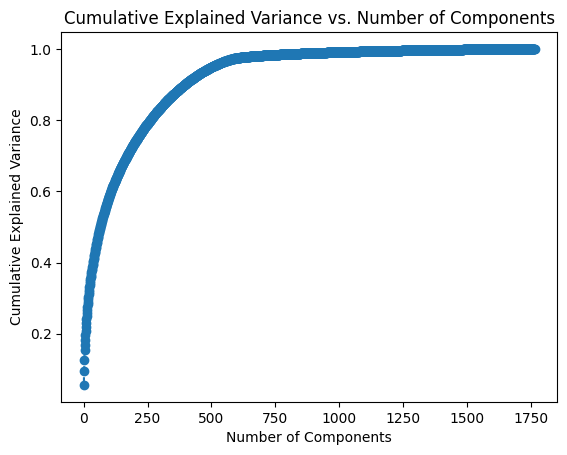

The first 600 components explains 97.48% of the variance in the dataset.


In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
x_train_pca = pca.fit_transform(x_train)

cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.show()
print(f"The first 600 components explains {cumulative_explained_variance[600]*100:0.2f}% of the variance in the dataset.")

In [ ]:
## 0.95% of the variance may be enough.
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
x_train_pca.shape

(15843, 503)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

model = SVC(probability=True, C=0.01, kernel='linear')

model.fit(x_train_pca, y_train)
predictions = model.predict(x_test_pca)

print(classification_report(y_train, model.predict(x_train_pca)))
print(classification_report(y_test, model.predict(x_test_pca)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5273
           1       1.00      1.00      1.00     10570

    accuracy                           1.00     15843
   macro avg       1.00      1.00      1.00     15843
weighted avg       1.00      1.00      1.00     15843

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1298
           1       0.99      0.99      0.99      2663

    accuracy                           0.99      3961
   macro avg       0.99      0.99      0.99      3961
weighted avg       0.99      0.99      0.99      3961



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],             # Regularization parameter
    'kernel': ['linear', 'rbf'],   # Kernel type
    'gamma': ['scale', 'auto'],    # Kernel coefficient
}

gridsearch = GridSearchCV(model, param_grid, n_jobs=3, scoring='precision')

gridsearch.fit(x_resampled, y_resampled)
model = gridsearch.best_estimator_

In [ ]:
# load the model if saved already to avoid re-training
# model = joblib.load('svm.joblib')

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', scaler),  # Standardize the features
    ('pca', pca),  # Apply PCA to capture 95% of variance
    ('svm', model) # Using the support vector machine classifier
])

In [ ]:
def non_maximum_suppression(boxes_and_scores, iou_threshold=0.5, score_threshold=0.5):

    to_remove = []
    for score in boxes_and_scores:
        if score[4] <= score_threshold:
            to_remove.append(score)

    for score in to_remove:
        boxes_and_scores.remove(score)

    sorted_boxes = sorted(boxes_and_scores, key=lambda x: x[4], reverse=True)

    keep = []
    while len(sorted_boxes) > 0:
        highest = sorted_boxes.pop(0)
        keep.append(highest)

        # Getting the area of the box with highest confidence score
        highest_area = (highest[2] - highest[0]) * (highest[3] - highest[1])

        suppress = []
        for i, box in enumerate(sorted_boxes):
            # Extract coordinates of intersection rectangle
            x_top_left = max(highest[0], box[0])
            y_top_left = max(highest[1], box[1])
            x_bottom_right = min(highest[2], box[2])
            y_bottom_right = min(highest[3], box[3])

            # Calculate width and height of intersection rectangle
            intersection_width = max(0, x_bottom_right - x_top_left)
            intersection_height = max(0, y_bottom_right - y_top_left)

            # Calculate intersection area
            intersection_area = intersection_width * intersection_height

            box_area = (box[2] - box[0]) * (box[3] - box[1])

            # Calculate the intersection over union
            iou = intersection_area / (box_area + highest_area - intersection_area)

            if iou >= iou_threshold:
                suppress.append(box)

        for box in suppress:
            sorted_boxes.remove(box)

    return keep

In [ ]:
cap = cv2.VideoCapture(0)

window_sizes = [(180, 180)]
step_size = 50 # You can adjust the stride

while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    confidence_scores = []
    for window_size in window_sizes:
        for y in range(0, frame.shape[0] - window_size[1], step_size):
            for x in range(0, frame.shape[1] - window_size[0], step_size):
                window = frame[y:y+window_size[1], x:x+window_size[0]]

                # Convert the resized window to grayscale
                gray_window = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)

                # Extract HOG features from the grayscale window
                features = extract_hog_features(gray_window, False)

                # Use the trained model to predict whether a face is present after scaling and applying pca
                prediction = pipeline.predict(features.reshape(1, -1))

                # If a face is predicted, draw a rectangle around the region in the original frame
                if prediction:
                    # getting the probability of the classification and collecting scores to be used in non-maximum supression
                    probs = pipeline.predict_proba(features.reshape(1, -1))[:,1]
                    confidence_scores.append([x, y, x+window_size[0], y+window_size[1], probs])

    bounding_boxes = non_maximum_suppression(confidence_scores, iou_threshold=0.1, score_threshold=0.7)

    if len(bounding_boxes) > 0:
        for box in confidence_scores:
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

        for box in bounding_boxes:
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

    # Display the frame with potential face detections
    cv2.imshow('Frame', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close the window
cap.release()
cv2.destroyAllWindows()

Saving the model.

In [ ]:
import joblib

model_filename = 'svm.joblib'
joblib.dump(model, model_filename)

['svm.joblib']